In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [15]:
#Loading the Dataframe
Dataset_std = pd.read_pickle("Data_te_std.pkl")
Dataset_norm = pd.read_pickle("Data_te_norm.pkl") 
Attack_label = pd.read_pickle("Attack_label.pkl")
Attack_type = pd.read_pickle("Attack_type.pkl")

# Working with smaller Dataset first
from sklearn.utils.random import sample_without_replacement
indices = sample_without_replacement(Dataset_std.shape[0],Dataset_std.shape[0]/5 , random_state=22)
Dataset_norm_short = pd.DataFrame(Dataset_norm.loc[indices.tolist()])
Dataset_std_short = pd.DataFrame(Dataset_std.loc[indices.tolist()])
Attack_label_short = pd.DataFrame(Attack_label.loc[indices.tolist()])

# mapping and then sampling
mapping_dict = {'DDoS_UDP': 1, 'DDoS_ICMP': 1, 'DDoS_HTTP': 1, 'DDoS_TCP': 1,
                'Port_Scanning': 2, 'Fingerprinting': 2, 'Vulnerability_scanner': 2,
                'MITM' : 3, 'XSS' : 4, 'SQL_injection': 4, 'Uploading':4, 
                'Backdoor': 5, 'Password': 5, 'Ransomware':5, 'Normal':6}
temp = Attack_type.map(mapping_dict)
Attack_type_short = pd.DataFrame(temp.loc[indices.tolist()])


Sampling

In [16]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state= 22)
Dataset_res, Target_res = sm.fit_resample(Dataset_std_short, Attack_type_short)
print("Before sampling: ", Attack_type_short.value_counts(sort= False, normalize = True))
print("After sampling: ", Target_res.value_counts(normalize = True))

Before sampling:  Attack_type
1              0.312579
2              0.133080
3              0.007161
4              0.196198
5              0.197782
6              0.153200
Name: proportion, dtype: float64
After sampling:  Attack_type
1              0.166667
2              0.166667
3              0.166667
4              0.166667
5              0.166667
6              0.166667
Name: proportion, dtype: float64


Splitting Training and Test Dataset

In [17]:
X = Dataset_res.to_numpy() 
Y = Target_res.to_numpy(dtype='int')
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=22) 
print("Train set: ", X_train.shape)
print("Test set: ", X_test.shape)

Train set:  (47352, 36)
Test set:  (11838, 36)


In [18]:
X_temp, X_val, Y_temp, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=22) 
print("Validation set: ", X_val.shape)

Validation set:  (9471, 36)


## Hyperparameter

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
parameters = {
    'n_neighbors': [2, 4, 6, 8, 10],
    'weights': ['uniform', 'distance'],
    'leaf_size': [20, 30, 40],
    'p': [1, 2]
}

grid_search = GridSearchCV(clf, param_grid= parameters, cv= 4).fit(X_val,Y_val)

print("Hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Hyperparameters:  {'leaf_size': 20, 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Best score:  0.7330811235427444


## Reference
1 = DDoS attacks<br>
2 = Scanning attacks<br>
3 = MITM attacks<br>
4 = Injection attacks<br> 
5 = Malware attacks<br>
6 = Normal<br>

## K-Neighbours

In [19]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors= 6, weights= 'distance', algorithm= 'auto', leaf_size= 20, p= 1)
neigh.fit(X_train, Y_train)
Y_pred = neigh.predict(X_test)

### Evaluation

Average Accuracy: 0.8053725291434364
   Precision    Recall  F1-Score
1   0.899877  0.772679  0.831442
2   0.830260  0.861206  0.845450
3   0.926214  1.000000  0.961694
4   0.643521  0.672114  0.657507
5   0.779199  0.728170  0.752821
6   0.760870  0.787500  0.773956


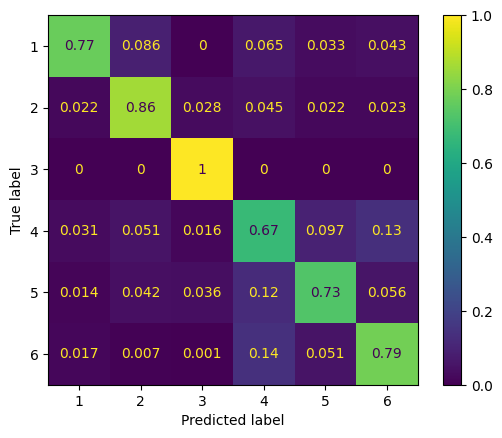

In [20]:
from sklearn import metrics
import numpy as np

# Confusion matrix
cm = metrics.confusion_matrix(Y_test, Y_pred, labels=neigh.classes_, normalize= 'true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot()

# Model Accuracy, Precision, Recall and F1-Score
print("Average Accuracy:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, average=None),
                        'Recall': metrics.recall_score(Y_test, Y_pred, average=None),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, average=None)}, index= neigh.classes_)
print(df_metric)

## Kneighbours after PCA

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)

neigh.fit(X_PCA, Y_train)
Y_pred = neigh.predict(X_test_PCA)

### Evaluation

Average Accuracy: 0.8023314749113026
   Precision    Recall  F1-Score
1   0.902115  0.787447  0.840890
2   0.851398  0.851398  0.851398
3   0.925790  1.000000  0.961465
4   0.640710  0.663943  0.652119
5   0.750270  0.722973  0.736368
6   0.749278  0.778500  0.763610


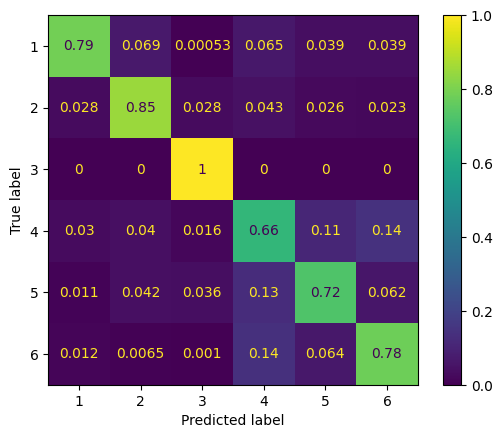

In [22]:
from sklearn import metrics
import numpy as np

# Confusion matrix
cm = metrics.confusion_matrix(Y_test, Y_pred, labels=neigh.classes_, normalize= 'true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot()

# Model Accuracy, Precision, Recall and F1-Score
print("Average Accuracy:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, average=None),
                        'Recall': metrics.recall_score(Y_test, Y_pred, average=None),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, average=None)}, index= neigh.classes_)
print(df_metric)

## KNeighbours after RF Feature Selection

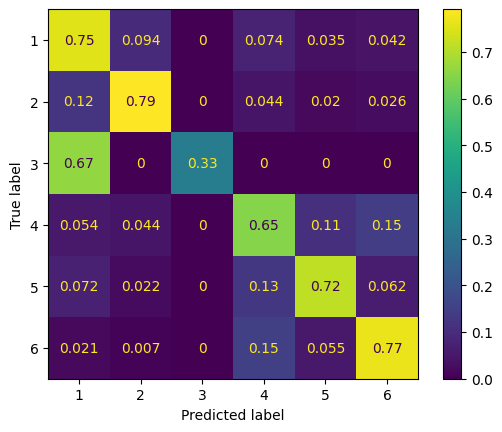

Average Accuracy: 0.6673424564960297
   Precision    Recall  F1-Score
1   0.432940  0.754219  0.550106
2   0.833764  0.792055  0.812374
3   1.000000  0.334983  0.501853
4   0.620166  0.647089  0.633342
5   0.761483  0.715177  0.737604
6   0.741188  0.767500  0.754114


In [23]:
import pickle as pkl
Features = pkl.load(open("Features_RFFS.pkl", "rb"))
X = Dataset_res[Features].to_numpy()
Y = Target_res.to_numpy(dtype='int')

# train test splitting 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=22) 

#training and predicting the model
neigh = KNeighborsClassifier(n_neighbors= 6, weights= 'distance', algorithm= 'auto', leaf_size= 20, p= 1)
neigh.fit(X_train, Y_train)
Y_pred = neigh.predict(X_test)


# confusion matrix
cm = metrics.confusion_matrix(Y_test, Y_pred, labels=neigh.classes_, normalize= 'true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= neigh.classes_)
disp.plot()
plt.show()

#accuracy calculation
print("Average Accuracy:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, average=None),
                        'Recall': metrics.recall_score(Y_test, Y_pred, average=None),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, average=None)}, index= neigh.classes_)
print(df_metric)

## Conclusion

The KNN produced almost similar result and used almost same computational time, for the normalised and standardised Dataset. The classification result shows that the Modal have average accurcay of 84% which is considered moderate.<br>
The modal shows considerable lacking of precision and recall by identifying the injection attacks (class = 4). To note is that 14% of Injection attacks are identified as Normal sample (class = 6).  